In [1]:
from pandas.core.frame import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras.utils import np_utils
import pandas as pd
import numpy as np
import random
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten , Activation, SimpleRNN, LSTM, GRU, Dropout, TimeDistributed, Reshape, Input, Lambda, Add
from tensorflow.keras import Sequential

In [2]:
def seed_tensorflow(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [3]:
def data_spli_to_fit(data):
    data = data.drop([0],axis=1)
    data = data.drop([1],axis=1)
    data = data.drop([2],axis=1)
    data = data.drop([3],axis=1)
    data[47] = data[47].fillna('Normal')
    data[47] = data[47].replace(' Fuzzers','Fuzzers')
    data[47] = data[47].replace(' Fuzzers ','Fuzzers')
    data[47] = data[47].replace(' Reconnaissance','Reconnaissance')
    data[47] = data[47].replace(' Reconnaissance ','Reconnaissance')
    data[47] = data[47].replace(' Shellcode','Shellcode')
    data[47] = data[47].replace(' Shellcode ','Shellcode')
    data[47] = data[47].replace('Backdoors','Backdoor')
    data = data.fillna(0)
    data[39] = data[39].replace(' ',0)
    data[39] = data[39].astype('int64')
    data_2_type = data[4].unique().tolist() 
    data_3_type = data[5].unique().tolist() 
    data_4_type = data[13].unique().tolist() 
    data = data.drop([48], axis=1) #删除Label
    data[4]= data[4].apply(lambda x : data_2_type.index(x))
    data[5] = data[5].apply(lambda x : data_3_type.index(x))
    data[13] = data[13].apply(lambda x : data_4_type.index(x))
    unlabled_data = data.drop([47],axis=1)
    return(unlabled_data, pd.DataFrame(data[47]))

def data_select(data, nums=100):
    data_43_type = data[47].unique().tolist()
    print(data_43_type) 
    print(data[47].value_counts())
    data[47] = data[47].apply(lambda x : data_43_type.index(x))
    r_data = DataFrame()
        
    for x in range(10):
        tp = data[data[47] == x]
        tp = shuffle(tp)
        tp = tp.iloc[1:nums+1]
        r_data = pd.concat([r_data, tp], ignore_index=True)
    data = shuffle(r_data)
    unlabeled_data  = data.drop([47],axis=1)
    res = np_utils.to_categorical(data[47], num_classes=10)
    return (unlabeled_data, res, data_43_type)

def data_s(data, sp_num):
    data_43_type = data[47].unique().tolist()
    print(data_43_type) 
    print(data[47].value_counts())
    data[47] = data[47].apply(lambda x : data_43_type.index(x))
    train_data = DataFrame()
    test_data = DataFrame()
    for x in range(0,len(sp_num)):
        tp = data[data[47] == x]
        train_data = pd.concat([train_data, tp.iloc[1:sp_num[x]+1]], ignore_index=True)
        test_data = pd.concat([test_data, tp.iloc[sp_num[x]+1:-1]], ignore_index=True) 
    train_data = shuffle(train_data)
    test_data = shuffle(test_data)
    ub_train = train_data.drop([47],axis=1)
    ub_test = test_data.drop([47],axis=1)
    train_res = np_utils.to_categorical(train_data[47], num_classes=10)
    test_res = np_utils.to_categorical(test_data[47], num_classes=10)
    return(train_data, train_res, test_data, test_res, data_43_type)

In [4]:
data = pd.concat([
    pd.read_csv('data/UNSW-NB15/archive/UNSW-NB15_1.csv', header=None),
    pd.read_csv('data/UNSW-NB15/archive/UNSW-NB15_2.csv', header=None),
    pd.read_csv('data/UNSW-NB15/archive/UNSW-NB15_3.csv', header=None),
    pd.read_csv('data/UNSW-NB15/archive/UNSW-NB15_4.csv', header=None)],
    ignore_index=True)

/home/jsm/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (1,3,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/jsm/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (3,39,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
(data,res) =  data_spli_to_fit(data)
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(data)
data = pd.DataFrame(scaler.transform(data))
data = pd.concat([data, res],axis=1)
#data.info()
sp_num = [1370880,23275,7608,8281,131435,811,13712,87,1371,1440]
(train_data, train_res, test_data, test_res, data_43_type) = data_s(data,sp_num)
#p.info()

['Normal', 'Exploits', 'Reconnaissance', 'DoS', 'Generic', 'Shellcode', 'Fuzzers', 'Worms', 'Backdoor', 'Analysis']
Normal            2218764
Generic            215481
Exploits            44525
Fuzzers             24246
DoS                 16353
Reconnaissance      13987
Analysis             2677
Backdoor             2329
Shellcode            1511
Worms                 174
Name: 47, dtype: int64


In [6]:
model = Sequential()
model.add(Reshape((-1,1), input_shape=(44,)))
model.add(Conv1D(32, 3, activation='relu', padding='causal'))
model.add(Conv1D(64, 3, activation='relu', padding='causal'))
model.add(MaxPooling1D(pool_size=2))
# model.add(LSTM(70, activation='tanh', recurrent_dropout=0.1, recurrent_activation = 'sigmoid'))
model.add(LSTM(70, recurrent_dropout=0.1))
model.add(Flatten())
model.add(Dense(10,activation='softmax'))
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.005), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

2022-01-09 11:43:27.425463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 11:43:27.432688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 11:43:27.433211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 11:43:27.434190: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
checkpoint_path = "save/tf/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [8]:
model.load_weights(checkpoint_path)

/home/jsm/miniconda3/lib/python3.8/site-packages/mlxtend/plotting/plot_confusion_matrix.py:94: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


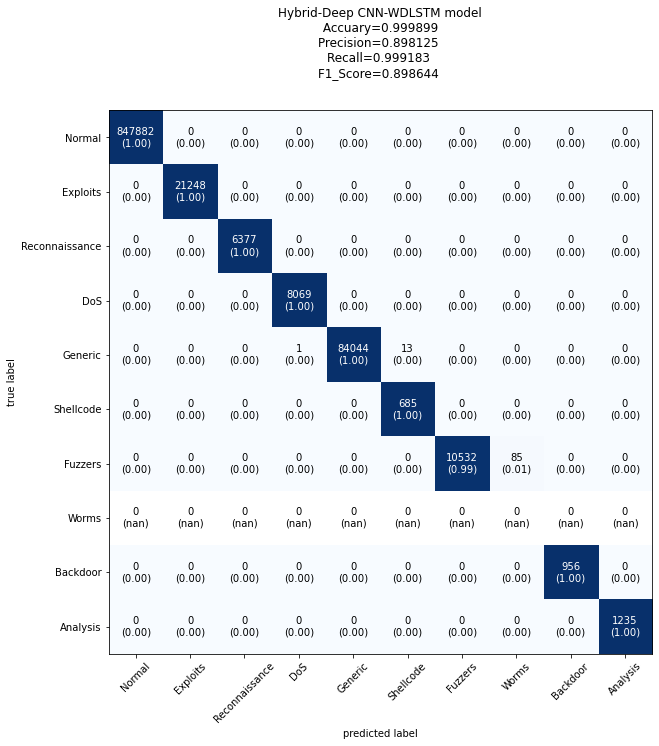

In [10]:
# model.evaluate(test_data,test_res)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

res = model.predict(test_data, batch_size=2048)
def confusion_plot(roi,res,title=None, class_name=None):
    fig, ax = plot_confusion_matrix(conf_mat = confusion_matrix(roi,res), class_names = class_name, show_absolute=True, show_normed=True, hide_spines=False, hide_ticks=False, figsize=(10,10))
    plt.title(title+'\n Accuary=%f \nPrecision=%f \nRecall=%f \nF1_Score=%f '%(
        accuracy_score(roi,res),
        precision_score(roi,res, average='macro', zero_division=1),
        recall_score(roi,res, average='macro', zero_division=1),
        f1_score(roi,res, average='macro', zero_division=1)
))
    plt.show()
confusion_plot(res.argmax(axis=-1), test_res.argmax(axis=-1), 'Hybrid-Deep CNN-WDLSTM model', data_43_type)